In [3]:
import sys
import logging
import multiprocessing as mp
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn import metrics
from sklearn.preprocessing import StandardScaler,LabelBinarizer
import pickle
import re

In [5]:
coef = pd.read_csv('hbm_coef_ds2.csv')
coef = coef.rename(columns={'Unnamed: 0': "coefficients"})
coef

,coefficients,mean,sd,hdi_3%,hdi_97%
0,beta_0[tox21-elg1-luc-agonist-p1],1.000,0.517,0.304,2.003
1,beta_0[tox21-ar-bla-antagonist-p1],0.992,0.520,0.279,1.993
2,beta_0[tox21-rt-viability-hek293-p1],0.996,0.521,0.302,1.989
3,beta_0[tox21-shh-3t3-gli3-agonist-p1],1.003,0.514,0.335,2.035
4,beta_0[tox21-ppard-bla-agonist-p1],0.994,0.518,0.259,1.987
...,...,...,...,...,...
6535,sigma_beta_5,0.023,0.020,0.001,0.056
6536,sigma_beta_6,0.033,0.023,0.000,0.077
6537,sigma_beta_7,0.034,0.023,0.000,0.070
6538,sigma_beta_8,0.037,0.023,0.000,0.075


In [6]:
feature_top_40 = ['fr_C_O', 'TPSA', 'SMR_VSA1', 'NumHAcceptors', 'NumAromaticCarbocycles','NumHeteroatoms',
                  'Chi4n', 'VSA_EState10', 'VSA_EState3', 'Kappa1', 'Chi2v', 'SMR_VSA10', 'SlogP_VSA2',
                  'HallKierAlpha', 'SMR_VSA5', 'VSA_EState7', 'FractionCSP3', 'SlogP_VSA10', 'BCUT2D_LOGPLOW',
                  'VSA_EState2', 'FpDensityMorgan2', 'fr_phenol_noOrthoHbond', 'SlogP_VSA1', 'PEOE_VSA1',
                  'fr_Ar_N', 'BCUT2D_CHGLO', 'fr_ether', 'EState_VSA1', 'MinPartialCharge', 'VSA_EState6',
                  'MaxPartialCharge', 'MinAbsPartialCharge', 'VSA_EState9', 'SMR_VSA3', 'FpDensityMorgan3',
                  'SlogP_VSA12', 'fr_Al_OH_noTert', 'BalabanJ', 'MaxAbsPartialCharge', 'EState_VSA10']
ridge_coef = pd.read_csv('/Users/wenyuzeng/Downloads/bal_acc_per_assay.csv')
assay_name = ridge_coef.assay.tolist()

In [13]:
coef_ds3 = coef[coef['coefficients'].str.startswith('beta_protocol')].reset_index(drop=True)
coef_ds3

,coefficients,mean,sd,hdi_3%,hdi_97%
0,"beta_protocol[tox21-elg1-luc-agonist-p1, beta_0]",1.007,0.515,0.284,1.983
1,"beta_protocol[tox21-elg1-luc-agonist-p1, beta_1]",-0.659,0.314,-1.271,-0.237
2,"beta_protocol[tox21-elg1-luc-agonist-p1, beta_2]",-0.820,0.502,-1.806,-0.132
3,"beta_protocol[tox21-elg1-luc-agonist-p1, beta_3]",-0.680,0.291,-1.217,-0.233
4,"beta_protocol[tox21-elg1-luc-agonist-p1, beta_4]",-0.322,0.067,-0.437,-0.204
...,...,...,...,...,...
1995,beta_protocol[tox21-er-luc-bg1-4e2-antagonist-...,-0.113,0.077,-0.260,0.034
1996,beta_protocol[tox21-er-luc-bg1-4e2-antagonist-...,-0.401,0.075,-0.543,-0.268
1997,beta_protocol[tox21-er-luc-bg1-4e2-antagonist-...,-0.856,0.085,-1.011,-0.694
1998,beta_protocol[tox21-er-luc-bg1-4e2-antagonist-...,0.163,0.063,0.044,0.283


In [15]:
coef_ds3['coefficients'] = coef_ds3['coefficients'].str.replace('[', ', ')
coef_ds3['coefficients'] = coef_ds3['coefficients'].str.replace(']', ', ')
coef_ds3[['A', 'assay', 'C','D']] = coef_ds3['coefficients'].str.split(", ",expand=True) 
coef_ds3

,coefficients,mean,sd,hdi_3%,hdi_97%,A,assay,C,D
0,"beta_protocol, tox21-elg1-luc-agonist-p1, beta...",1.007,0.515,0.284,1.983,beta_protocol,tox21-elg1-luc-agonist-p1,beta_0,
1,"beta_protocol, tox21-elg1-luc-agonist-p1, beta...",-0.659,0.314,-1.271,-0.237,beta_protocol,tox21-elg1-luc-agonist-p1,beta_1,
2,"beta_protocol, tox21-elg1-luc-agonist-p1, beta...",-0.820,0.502,-1.806,-0.132,beta_protocol,tox21-elg1-luc-agonist-p1,beta_2,
3,"beta_protocol, tox21-elg1-luc-agonist-p1, beta...",-0.680,0.291,-1.217,-0.233,beta_protocol,tox21-elg1-luc-agonist-p1,beta_3,
4,"beta_protocol, tox21-elg1-luc-agonist-p1, beta...",-0.322,0.067,-0.437,-0.204,beta_protocol,tox21-elg1-luc-agonist-p1,beta_4,
...,...,...,...,...,...,...,...,...,...
1995,"beta_protocol, tox21-er-luc-bg1-4e2-antagonist...",-0.113,0.077,-0.260,0.034,beta_protocol,tox21-er-luc-bg1-4e2-antagonist-p1,beta_35,
1996,"beta_protocol, tox21-er-luc-bg1-4e2-antagonist...",-0.401,0.075,-0.543,-0.268,beta_protocol,tox21-er-luc-bg1-4e2-antagonist-p1,beta_36,
1997,"beta_protocol, tox21-er-luc-bg1-4e2-antagonist...",-0.856,0.085,-1.011,-0.694,beta_protocol,tox21-er-luc-bg1-4e2-antagonist-p1,beta_37,
1998,"beta_protocol, tox21-er-luc-bg1-4e2-antagonist...",0.163,0.063,0.044,0.283,beta_protocol,tox21-er-luc-bg1-4e2-antagonist-p1,beta_38,


In [16]:
coef_ds3.assay = coef_ds3.assay.astype('str')
# coef_ds3.sort_values(by='assay')

In [22]:
meta_info_coef = coef_ds3.iloc[:,1:]
meta_info_coef[['beta', "descriptor"]] = meta_info_coef['C'].str.split("_",expand=True)
meta_info_coef.descriptor = meta_info_coef.descriptor.astype('int64')
meta_info_coef

,mean,sd,hdi_3%,hdi_97%,A,assay,C,D,beta,descriptor
0,1.007,0.515,0.284,1.983,beta_protocol,tox21-elg1-luc-agonist-p1,beta_0,,beta,0
1,-0.659,0.314,-1.271,-0.237,beta_protocol,tox21-elg1-luc-agonist-p1,beta_1,,beta,1
2,-0.820,0.502,-1.806,-0.132,beta_protocol,tox21-elg1-luc-agonist-p1,beta_2,,beta,2
3,-0.680,0.291,-1.217,-0.233,beta_protocol,tox21-elg1-luc-agonist-p1,beta_3,,beta,3
4,-0.322,0.067,-0.437,-0.204,beta_protocol,tox21-elg1-luc-agonist-p1,beta_4,,beta,4
...,...,...,...,...,...,...,...,...,...,...
1995,-0.113,0.077,-0.260,0.034,beta_protocol,tox21-er-luc-bg1-4e2-antagonist-p1,beta_35,,beta,35
1996,-0.401,0.075,-0.543,-0.268,beta_protocol,tox21-er-luc-bg1-4e2-antagonist-p1,beta_36,,beta,36
1997,-0.856,0.085,-1.011,-0.694,beta_protocol,tox21-er-luc-bg1-4e2-antagonist-p1,beta_37,,beta,37
1998,0.163,0.063,0.044,0.283,beta_protocol,tox21-er-luc-bg1-4e2-antagonist-p1,beta_38,,beta,38


In [24]:
coef_ds2 = meta_info_coef.iloc[:,[0,1,5, 9]]
coef_ds2

,mean,sd,assay,descriptor
0,1.007,0.515,tox21-elg1-luc-agonist-p1,0
1,-0.659,0.314,tox21-elg1-luc-agonist-p1,1
2,-0.820,0.502,tox21-elg1-luc-agonist-p1,2
3,-0.680,0.291,tox21-elg1-luc-agonist-p1,3
4,-0.322,0.067,tox21-elg1-luc-agonist-p1,4
...,...,...,...,...
1995,-0.113,0.077,tox21-er-luc-bg1-4e2-antagonist-p1,35
1996,-0.401,0.075,tox21-er-luc-bg1-4e2-antagonist-p1,36
1997,-0.856,0.085,tox21-er-luc-bg1-4e2-antagonist-p1,37
1998,0.163,0.063,tox21-er-luc-bg1-4e2-antagonist-p1,38


In [36]:
coef_assay_list = []
for i in np.unique(list(coef_ds2.assay)):
    assay_df = coef_ds2[coef_ds2.assay == i].reset_index(drop=True)
    assay_df = assay_df[['mean']]
    assay_df = assay_df.rename(columns={'mean': i})
    coef_assay_list.append(assay_df)

In [39]:
mean_df = pd.concat(coef_assay_list, axis=1)
mean_df['Features'] = feature_top_40
mean_df = mean_df.set_index('Features')
mean_df

,tox21-ahr-p1,tox21-ap1-agonist-p1,tox21-ar-bla-antagonist-p1,tox21-ar-mda-kb2-luc-agonist-p3,tox21-ar-mda-kb2-luc-antagonist-p1,tox21-ar-mda-kb2-luc-antagonist-p2,tox21-are-bla-p1,tox21-aromatase-p1,tox21-car-agonist-p1,tox21-car-antagonist-p1,...,tox21-ror-cho-antagonist-p1,tox21-rt-viability-hek293-p1,tox21-rt-viability-hepg2-p1,tox21-rxr-bla-agonist-p1,tox21-sbe-bla-agonist-p1,tox21-sbe-bla-antagonist-p1,tox21-shh-3t3-gli3-agonist-p1,tox21-shh-3t3-gli3-antagonist-p1,tox21-vdr-bla-agonist-p1,tox21-vdr-bla-antagonist-p1
Features,,,,,,,,,,,,,,,,,,,,,
fr_C_O,1.017,1.015,0.981,1.004,0.978,1.007,0.995,0.998,1.014,1.020,...,0.981,0.999,0.970,0.999,0.994,0.983,1.019,1.004,0.990,0.981
TPSA,-0.670,-0.686,-0.664,-0.676,-0.689,-0.676,-0.662,-0.675,-0.664,-0.651,...,-0.669,-0.654,-0.669,-0.637,-0.678,-0.677,-0.648,-0.662,-0.662,-0.668
SMR_VSA1,-0.795,-0.766,-0.841,-0.823,-0.792,-0.797,-0.836,-0.811,-0.798,-0.817,...,-0.805,-0.854,-0.835,-0.879,-0.787,-0.841,-0.818,-0.810,-0.852,-0.859
NumHAcceptors,-0.685,-0.681,-0.684,-0.681,-0.698,-0.674,-0.677,-0.684,-0.670,-0.677,...,-0.687,-0.677,-0.700,-0.673,-0.688,-0.686,-0.681,-0.682,-0.688,-0.686
NumAromaticCarbocycles,-0.328,-0.328,-0.329,-0.339,-0.325,-0.322,-0.328,-0.312,-0.322,-0.318,...,-0.318,-0.337,-0.309,-0.344,-0.324,-0.314,-0.328,-0.325,-0.321,-0.331
NumHeteroatoms,0.244,0.095,0.210,0.143,0.171,0.108,0.123,0.226,0.178,0.226,...,0.129,0.221,0.150,0.151,0.101,0.164,0.138,0.159,0.158,0.185
Chi4n,0.128,0.202,0.179,0.258,0.267,0.265,0.362,0.205,0.217,0.227,...,0.419,0.040,0.554,0.116,0.419,0.394,0.264,0.185,0.337,0.240
VSA_EState10,-0.470,-0.420,-0.438,-0.449,-0.476,-0.468,-0.387,-0.408,-0.480,-0.449,...,-0.365,-0.338,-0.505,-0.319,-0.416,-0.448,-0.429,-0.438,-0.334,-0.397
VSA_EState3,-0.217,-0.143,-0.135,-0.196,-0.214,-0.171,-0.143,-0.136,-0.180,-0.212,...,-0.137,-0.149,-0.208,-0.107,-0.166,-0.148,-0.135,-0.145,-0.159,-0.116


<Figure size 3000x3000 with 0 Axes>

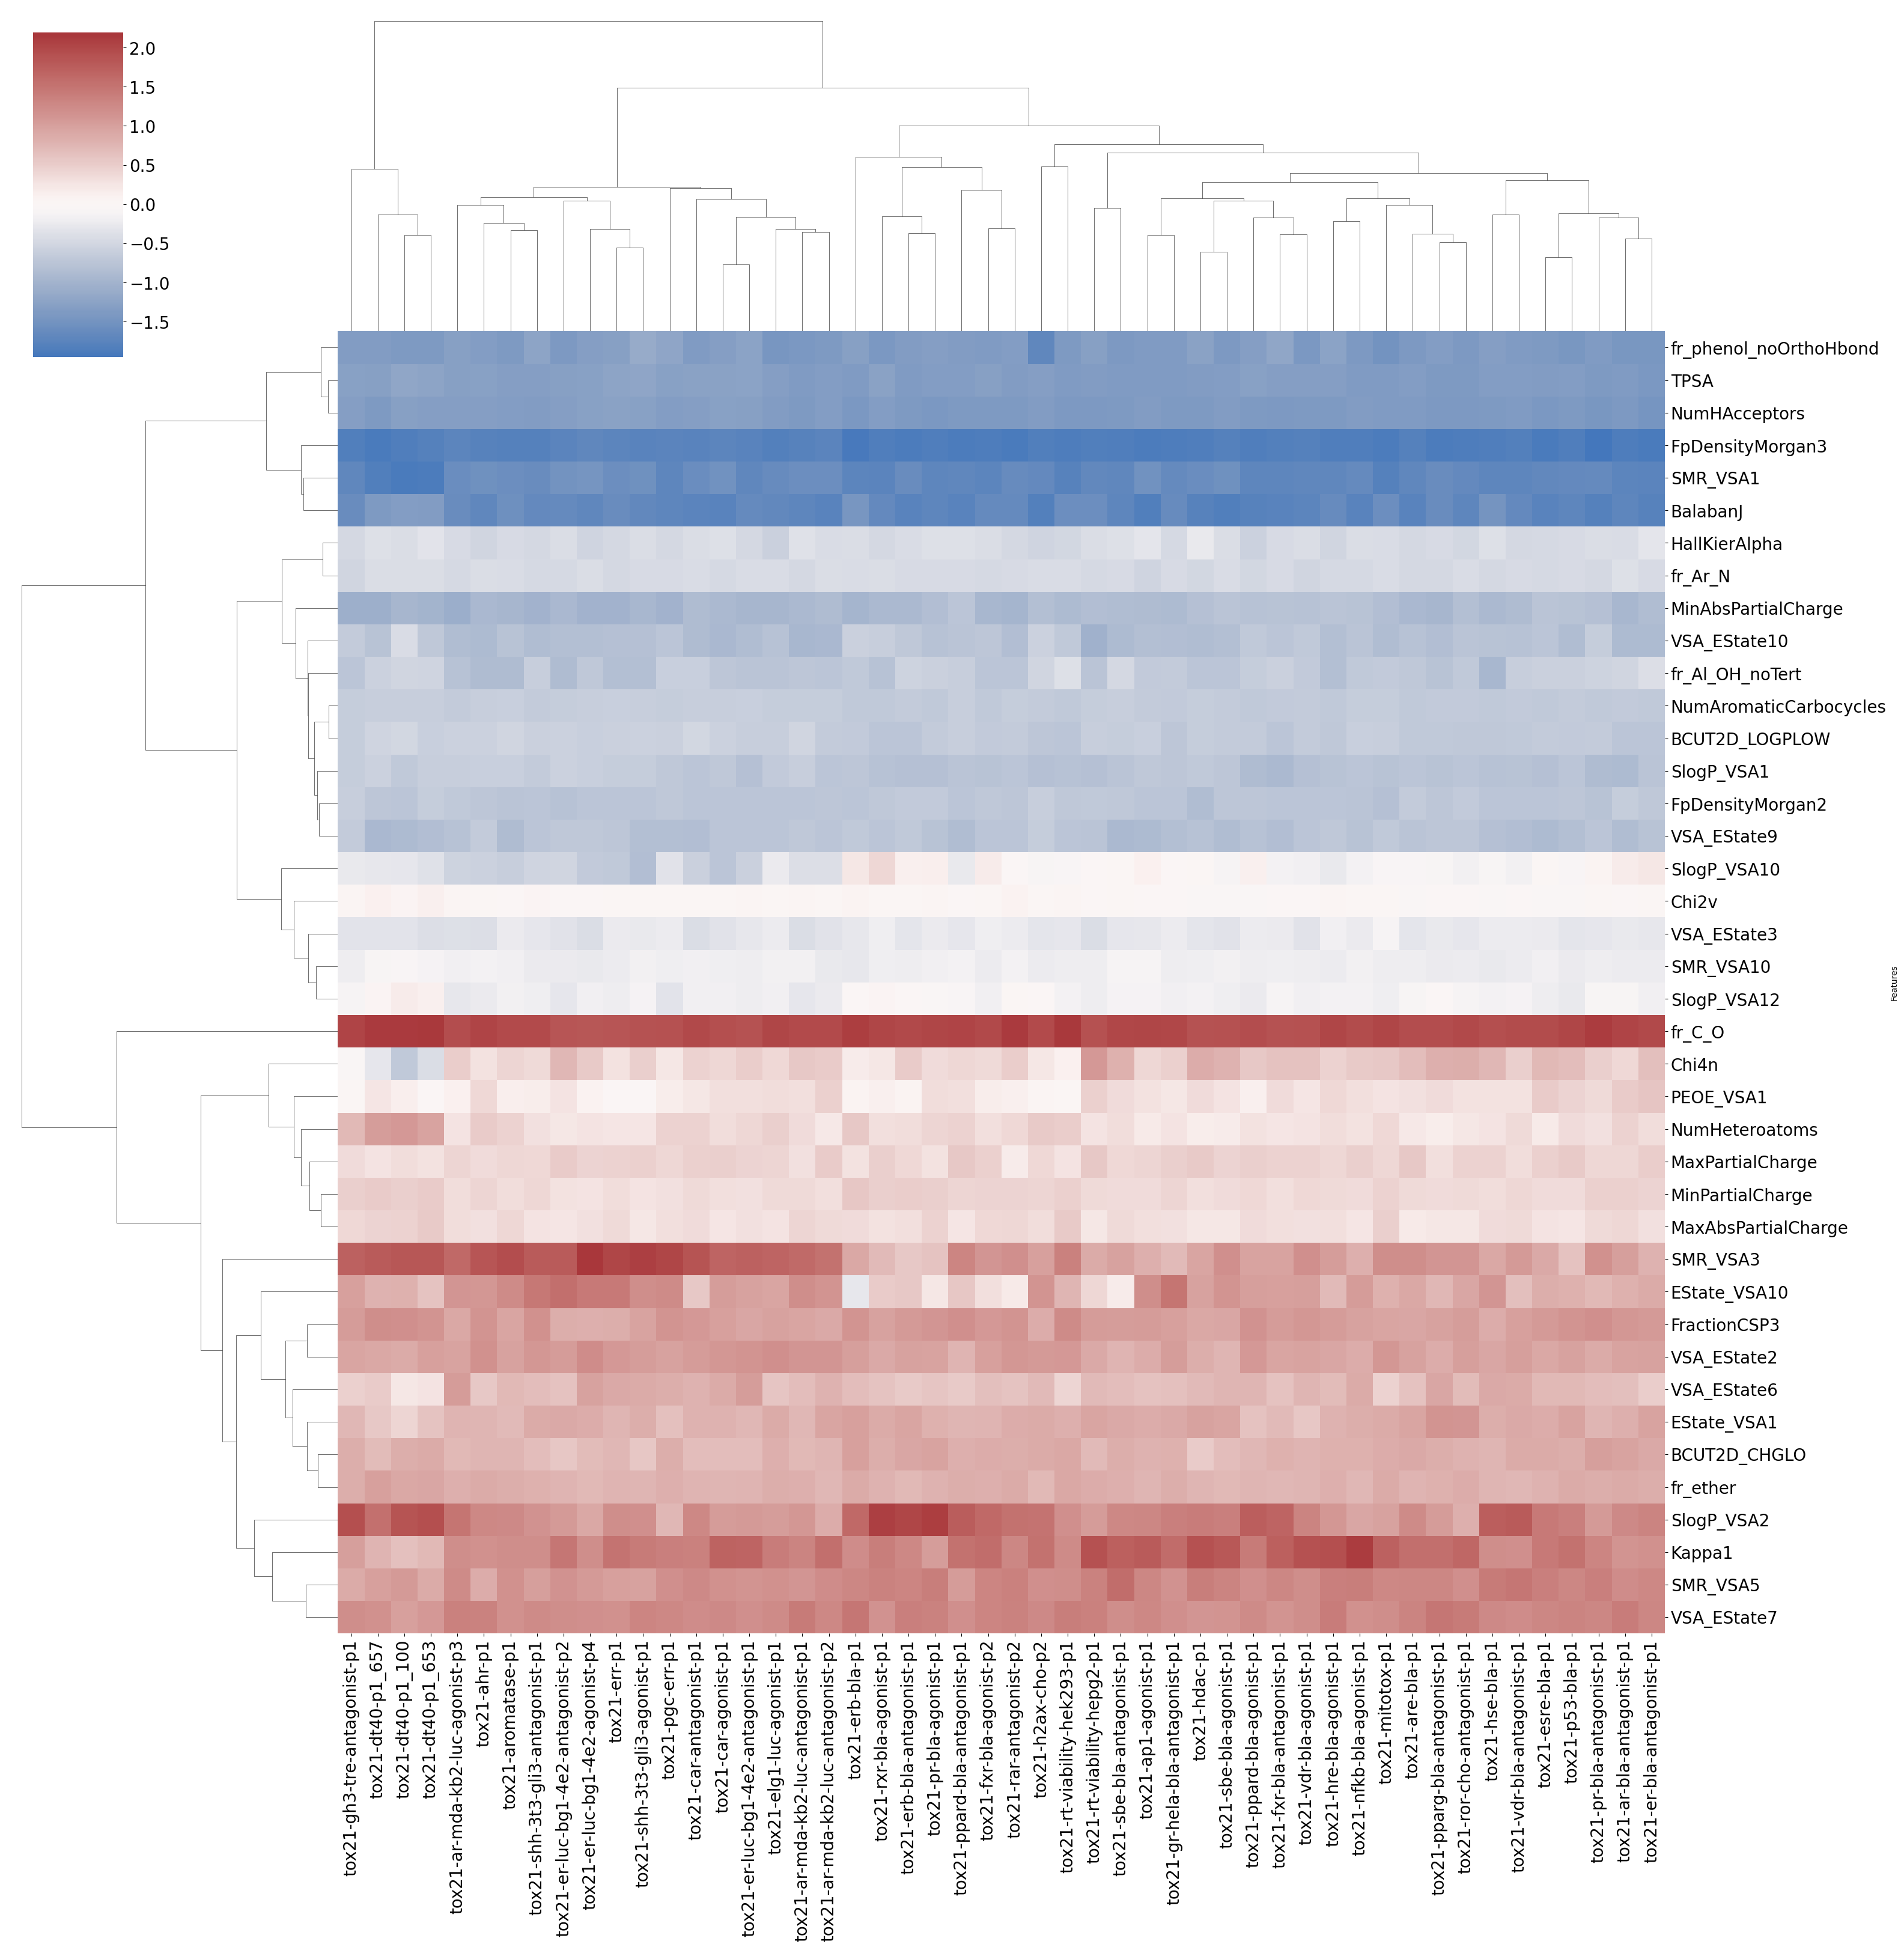

In [44]:
fig = plt.figure(figsize = (30,30))
# ax = sns.heatmap(fea_df.set_index('features'), cmap='vlag')
ax = sns.clustermap(mean_df, cmap = 'vlag', z_score = 1, center=0, figsize=(30, 30))
# ax.axes.set_title('Assay by Features heatmap',fontsize=30)
# ax.set_xlabel("Assays",fontsize=20)
# ax.set_ylabel("Features",fontsize=20)
ax.tick_params(labelsize=20)
# cbar = ax.collections[0].colorbar
# cbar.ax.tick_params(labelsize=20)

plt.savefig('Feature_importance_HBM_ds2.tiff', bbox_inches="tight", dpi=300)
plt.show()

### Horizontal Barplot, using absolute values

In [45]:
# mean_df_abs = abs(mean_df)
mean_df_abs = mean_df.copy(deep=True)
mean_df_abs['mean_val'] = np.mean(mean_df_abs,axis=1)
mean_df_abs['std_val'] = np.std(mean_df_abs.iloc[:,:-1], axis=1)
mean_df_abs

,tox21-ahr-p1,tox21-ap1-agonist-p1,tox21-ar-bla-antagonist-p1,tox21-ar-mda-kb2-luc-agonist-p3,tox21-ar-mda-kb2-luc-antagonist-p1,tox21-ar-mda-kb2-luc-antagonist-p2,tox21-are-bla-p1,tox21-aromatase-p1,tox21-car-agonist-p1,tox21-car-antagonist-p1,...,tox21-rt-viability-hepg2-p1,tox21-rxr-bla-agonist-p1,tox21-sbe-bla-agonist-p1,tox21-sbe-bla-antagonist-p1,tox21-shh-3t3-gli3-agonist-p1,tox21-shh-3t3-gli3-antagonist-p1,tox21-vdr-bla-agonist-p1,tox21-vdr-bla-antagonist-p1,mean_val,std_val
Features,,,,,,,,,,,,,,,,,,,,,
fr_C_O,1.017,1.015,0.981,1.004,0.978,1.007,0.995,0.998,1.014,1.020,...,0.970,0.999,0.994,0.983,1.019,1.004,0.990,0.981,0.99574,0.014311
TPSA,-0.670,-0.686,-0.664,-0.676,-0.689,-0.676,-0.662,-0.675,-0.664,-0.651,...,-0.669,-0.637,-0.678,-0.677,-0.648,-0.662,-0.662,-0.668,-0.66376,0.013877
SMR_VSA1,-0.795,-0.766,-0.841,-0.823,-0.792,-0.797,-0.836,-0.811,-0.798,-0.817,...,-0.835,-0.879,-0.787,-0.841,-0.818,-0.810,-0.852,-0.859,-0.83360,0.039462
NumHAcceptors,-0.685,-0.681,-0.684,-0.681,-0.698,-0.674,-0.677,-0.684,-0.670,-0.677,...,-0.700,-0.673,-0.688,-0.686,-0.681,-0.682,-0.688,-0.686,-0.68578,0.009248
NumAromaticCarbocycles,-0.328,-0.328,-0.329,-0.339,-0.325,-0.322,-0.328,-0.312,-0.322,-0.318,...,-0.309,-0.344,-0.324,-0.314,-0.328,-0.325,-0.321,-0.331,-0.32604,0.008025
NumHeteroatoms,0.244,0.095,0.210,0.143,0.171,0.108,0.123,0.226,0.178,0.226,...,0.150,0.151,0.101,0.164,0.138,0.159,0.158,0.185,0.18900,0.083953
Chi4n,0.128,0.202,0.179,0.258,0.267,0.265,0.362,0.205,0.217,0.227,...,0.554,0.116,0.419,0.394,0.264,0.185,0.337,0.240,0.22590,0.167648
VSA_EState10,-0.470,-0.420,-0.438,-0.449,-0.476,-0.468,-0.387,-0.408,-0.480,-0.449,...,-0.505,-0.319,-0.416,-0.448,-0.429,-0.438,-0.334,-0.397,-0.39766,0.053455
VSA_EState3,-0.217,-0.143,-0.135,-0.196,-0.214,-0.171,-0.143,-0.136,-0.180,-0.212,...,-0.208,-0.107,-0.166,-0.148,-0.135,-0.145,-0.159,-0.116,-0.14708,0.036609


In [47]:
h_coe = mean_df_abs.sort_values(by=['mean_val'], ascending=True).iloc[:,-2:].reset_index()
h_coe = h_coe.sort_values(by=['mean_val'], ascending=True).reset_index(drop=True)
h_coe = h_coe.set_index('Features')

In [48]:
categories = []
for i in h_coe.index:
    if i.startswith('fr_'):
        categories.append('Fraction of a substructure')
    elif i.startswith('PEOE'):
        categories.append('MOE type - Partial Charges')
    elif i.startswith('SlogP'):
        categories.append('MOE type - LogP')
    elif i.startswith('SMR'):
        categories.append('MOE type - MR')
    elif i.startswith('EState') or i.startswith('VSA'):
        categories.append('MOE type - EState')
    elif i.startswith('BCUT2D'):
        categories.append('BCUT type')
    else:
        categories.append('physicochemical properties')
h_coe['category'] = categories
h_coe

,mean_val,std_val,category
Features,,,
FpDensityMorgan3,-0.91926,0.014253,physicochemical properties
BalabanJ,-0.83880,0.060428,physicochemical properties
SMR_VSA1,-0.83360,0.039462,MOE type - MR
NumHAcceptors,-0.68578,0.009248,physicochemical properties
fr_phenol_noOrthoHbond,-0.68272,0.041668,Fraction of a substructure
TPSA,-0.66376,0.013877,physicochemical properties
MinAbsPartialCharge,-0.45260,0.051533,physicochemical properties
VSA_EState10,-0.39766,0.053455,MOE type - EState
VSA_EState9,-0.39022,0.039283,MOE type - EState


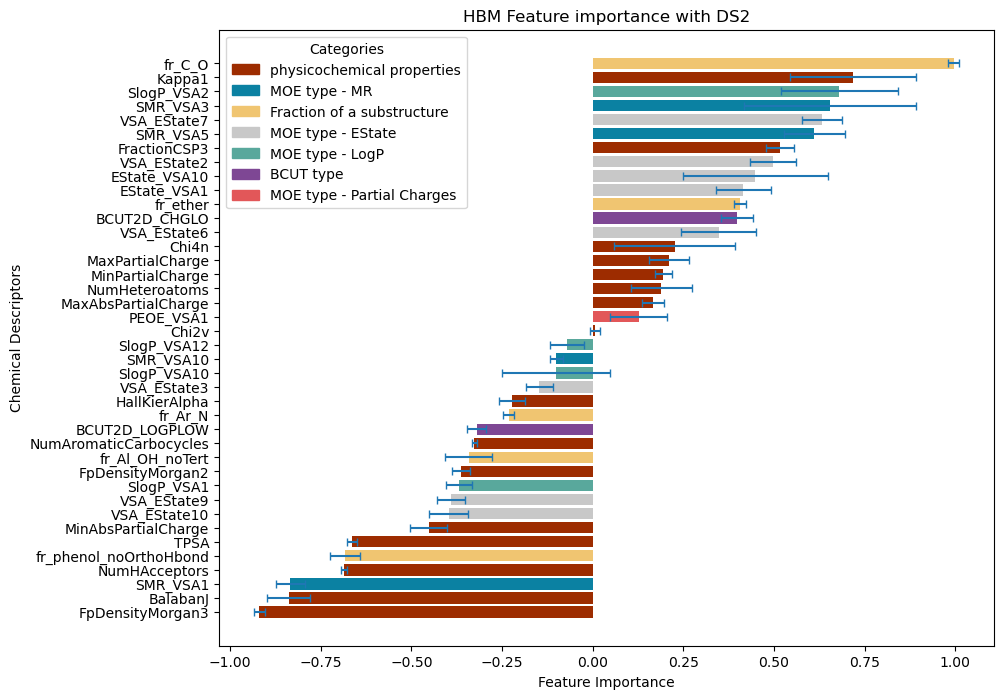

In [55]:
h_coe_plot = h_coe.reset_index()
f, ax = plt.subplots(figsize=(10, 8))
colors = {'MOE type - EState': '#c8c8c8', 'Fraction of a substructure': '#f0c571', 'MOE type - LogP': '#59a89c',
          'MOE type - MR':'#0b81a2', 'MOE type - Partial Charges': '#e25759',
          'physicochemical properties': '#9d2c00', 'BCUT type': '#7E4794', 'assay_meta_info': '36b700'}
plt.barh(data = h_coe_plot, y='Features', width='mean_val', color=[colors[i] for i in h_coe_plot.category])
plt.errorbar(data = h_coe_plot, y='Features', x='mean_val', xerr = 'std_val', fmt ='none', capsize=3)

labels = h_coe['category'].unique()
handles = [plt.Rectangle((0,0),1,1, color=colors[l]) for l in labels]
plt.legend(handles, labels, title="Categories")
plt.title('HBM Feature importance with DS2')
plt.xlabel('Feature Importance')
plt.ylabel('Chemical Descriptors')
plt.savefig('Feature_importance_HBM_DS2.tiff', dpi=300, bbox_inches='tight')
plt.show()

In [56]:
ls = [0,1,2,3,4,5,6]
ls[1:5]

[1, 2, 3, 4]